# This is an interactive notebook for the population model
* input parameters for this model are: year, country, and demogrophic group

In [1]:
import os
import glob
os.chdir("/usr/src/app")

In [2]:
import datetime

import ipywidgets as widgets
import luigi
from luigi.parameter import DateIntervalParameter
from luigi.date_interval import Custom as CustomDateInterval

from models.population_model.tasks import HiResPopRasterMasked

In [3]:
# use interactive, not interact to easily access the input value!

year = widgets.IntSlider(description='Year:', orientation='horizontal', step=1, min=2010, max=2020, value=2018)

def input_val(x):
    return str(x)

yr_wd=widgets.interactive(input_val, x=year)
display(yr_wd)

country_wd=widgets.Dropdown(
    options=['Ethiopia','South Sudan'],
    description='Country:',
    disabled=False,
)
display(country_wd)

band_wd=widgets.Dropdown(
    options=['total','male','female','0-4yr','5-9yr',
            '10-14yr','15-19yr','20-24yr','25-29yr',
            '30-34yr','35-39yr','40-44yr','45-49yr',
            '50-54yr', '55-59yr','60-64yr','65-69yr',
            '70-74yr', '75-79yr','80-84yr','85-89yr',
            '90-94yr','>95yr'],
    description='Demographic:',
    disabled=False,
)
display(band_wd)

interactive(children=(IntSlider(value=2018, description='Year:', max=2020, min=2010), Output()), _dom_classes=…

Dropdown(description='Country:', options=('Ethiopia', 'South Sudan'), value='Ethiopia')

Dropdown(description='Demographic:', options=('total', 'male', 'female', '0-4yr', '5-9yr', '10-14yr', '15-19yr…

In [4]:
raster_band_dict=dict()
def Convert(tup, di): 
    for i, k in enumerate(tup): 
        di.setdefault(k, []).append(i+1) 
    return di

In [5]:
band_dictionary = Convert(band_wd.options, raster_band_dict)
del raster_band_dict

In [6]:
# for population model, only the year time point is needed.
timepoint = yr_wd.result+'-'+'01-01-'+yr_wd.result+'-'+'06-01'

## This runs the population model based on User defined input

In [7]:
# for Ethiopia, define geography
eth_geo_file = {"coordinates": [[[36.357226629663501, 14.272502682267801],[37.2970544510355, 14.6772882598167],[37.719862777828297, 15.0348782791802],[38.406926308866502, 14.8050668691039],[40.0981596160373, 14.4726873923002],[41.630839800661001, 13.4982974690825],[42.529307495095502, 12.365084475553299],[41.921520525330997, 11.1750924233907],[42.925690301463703, 11.1750924233907],[43.004966862737298, 10.578226842108799],[44.141264240992797, 9.224600687836],[47.033937477102299, 8.239013541804599],[48.343304299598302, 8.21360385046173],[45.151070168399599, 4.73902070129281],[43.621706074706402, 4.59611835261279],[42.379097748580598, 3.85735258666634],[41.255970992274698, 3.73813341072871],[40.730252085067598, 4.02423122213936],[39.631021642725599, 3.30881385146286],[38.8185469679511, 3.30881385146286],[38.029968607140503, 3.42808897514322],[36.906841850834503, 4.19107567031119],[35.9031966643484, 4.28639946386431],[35.568648268853003, 5.04853993824516],[35.042929361645903, 5.23894050051229],[34.732277280114502, 6.38005314679845],[32.772779535070001, 7.87384558608177],[33.035638988673597, 8.583349846796411],[33.872009977412098, 8.65422922148511],[34.134869431015602, 10.656535086660901],[36.357226629663501, 14.272502682267801]]], "type": "Polygon"}

In [8]:
pop_hires = HiResPopRasterMasked(
    time=DateIntervalParameter().parse(timepoint),
    rainfall_scenario="normal",
    country_level=country_wd.value,
    geography=eth_geo_file,
    rainfall_scenario_geography=eth_geo_file
    )

In [9]:
luigi.build([pop_hires], local_scheduler=True, no_lock=True)

[2020-03-30 16:27:47,306] INFO [luigi:80] logging configured via *.conf file
[2020-03-30 16:27:47,385] INFO [luigi-interface:104] ExpiringLocalTarget 'output/intermediate/models.population_model.tasks.HiResPopRasterMasked_admin2_Ethiopia___coordinates____0fa91147c8/_0fa91147c8.pickle' expired 385s ago at 2020-03-30 16:21:22.005947+00:00 and has been removed
TASK PARAMETERS: {'admin_level': 'admin2', 'country_level': 'Ethiopia', 'time': 2018-01-01-2018-06-01, 'geography': {'coordinates': [[[36.3572266296635, 14.2725026822678], [37.2970544510355, 14.6772882598167], [37.7198627778283, 15.0348782791802], [38.4069263088665, 14.8050668691039], [40.0981596160373, 14.4726873923002], [41.630839800661, 13.4982974690825], [42.5293074950955, 12.3650844755533], [41.921520525331, 11.1750924233907], [42.9256903014637, 11.1750924233907], [43.0049668627373, 10.5782268421088], [44.1412642409928, 9.224600687836], [47.0339374771023, 8.2390135418046], [48.3433042995983, 8.21360385046173], [45.1510701683996

True

In [10]:
# find the output tiffs, and pass the first to plot
target = pop_hires.output().path
hires_raster = glob.glob(target + '/*.tiff')[0]

In [11]:
def plot_raster(raster_tiff, plot_title="", scale='normal', band=1):
    """
    raster_tiff: path to the raster .tiff file
    """
    
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import gdal
    import numpy as np
    
    srcfile=gdal.Open(raster_tiff)
    src_band=srcfile.GetRasterBand(band).ReadAsArray().astype(np.float)
    ref_proj = srcfile.GetProjection()
    ref_geotrans = srcfile.GetGeoTransform()
    nrows = srcfile.RasterYSize
    ncols = srcfile.RasterXSize
    no_data_val = srcfile.GetRasterBand(1).GetNoDataValue()
    ulx, xres, xskew, uly, yskew, yres  = ref_geotrans
    lrx = ulx + (ncols * xres)
    lry = uly + (nrows * yres)
    img_extent = (ulx, lrx, lry, uly)
    srcfile = None

    src_band[src_band==no_data_val] = np.nan
    
    fig = plt.figure(figsize=(14, 14))
    ax = plt.axes(projection=ccrs.PlateCarree())
    cmap = mpl.cm.YlGnBu #terrain
    
    cmap.set_bad('#e5e6e8')
    if scale=='log':
        h = ax.imshow(src_band, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), 
                      cmap=cmap,norm=mpl.colors.LogNorm())
    else: 
        h = ax.imshow(src_band, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), 
                      cmap=cmap)
    
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    plt.colorbar(h, cax=ax_cb)
  
    ax.set_title(plot_title +'-'+band_wd.value+' ('+scale+')', fontsize=24)


/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


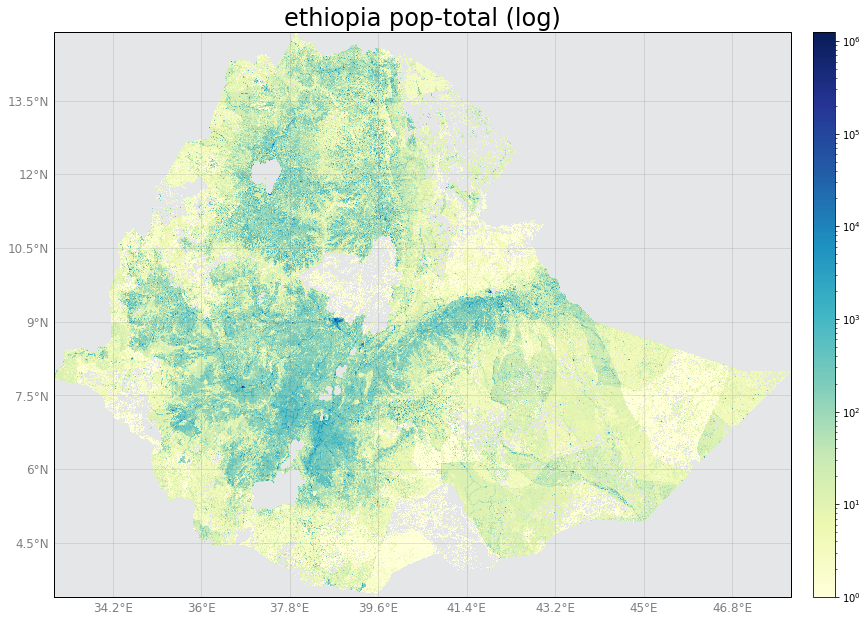

In [12]:
plot_raster(hires_raster, 'ethiopia pop', scale='log', band=band_dictionary[band_wd.value][0])

In [13]:
pop_zonal = pop_hires.requires()[0].requires()[0]
target = pop_zonal.output().path
county_raster = glob.glob(target + '/*.tiff')[0]

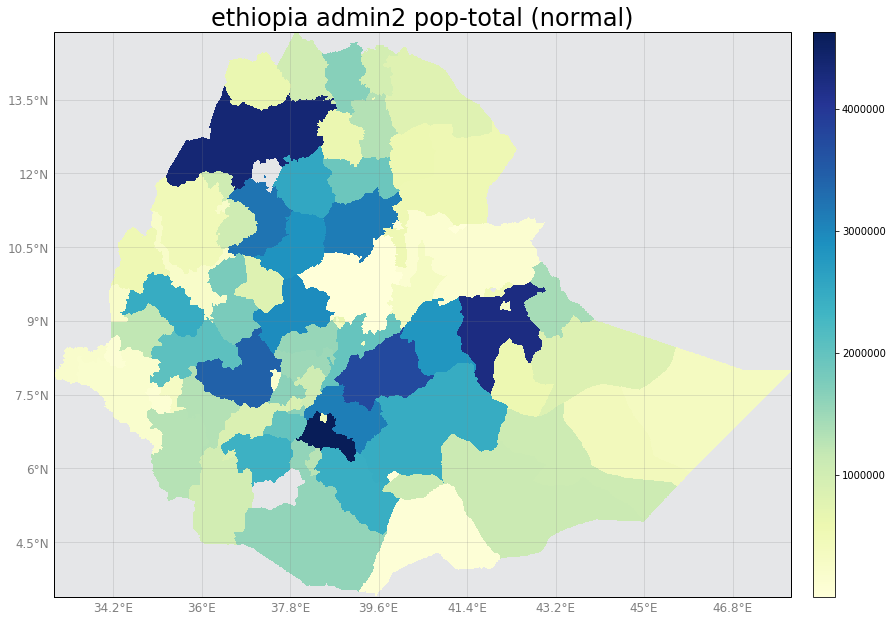

In [14]:
fname2=county_raster
plot_raster(fname2, 'ethiopia admin2 pop', band=band_dictionary[band_wd.value][0])